In [1]:
import torch
from transformers import ViTFeatureExtractor, AutoTokenizer, CLIPFeatureExtractor, AutoModel, AutoModelForCausalLM
from transformers.models.auto.configuration_auto import AutoConfig
from src.vision_encoder_decoder import SmallCap, SmallCapConfig
from src.gpt2 import ThisGPT2Config, ThisGPT2LMHeadModel
from src.utils import prep_strings, postprocess_preds

image_path = 'data/image_truck.jpg'
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# load feature extractor
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")

# load and configure tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = '!'
tokenizer.eos_token = '.'

# load model
AutoConfig.register("this_gpt2", ThisGPT2Config)
AutoModel.register(ThisGPT2Config, ThisGPT2LMHeadModel)
AutoModelForCausalLM.register(ThisGPT2Config, ThisGPT2LMHeadModel)
AutoConfig.register("smallcap", SmallCapConfig)
AutoModel.register(SmallCapConfig, SmallCap)
model = AutoModel.from_pretrained("Yova/SmallCap7M")
model= model.to(device)

template = open('src/template.txt').read().strip() + ' '

In [3]:
# precompute captions for retrieval
import json

from src.retrieve_caps import *

captions = json.load(open('datastore/coco_index_captions.json'))
retrieval_model, feature_extractor_retrieval = clip.load("RN50x64", device=device)
retrieval_index = faiss.read_index('datastore/coco_index')
res = faiss.StandardGpuResources()  
retrieval_index = faiss.index_cpu_to_gpu(res, 0, retrieval_index)

In [4]:
def retrieve_caps(image_embedding, index, k=4):
    xq = image_embedding.astype(np.float32)
    faiss.normalize_L2(xq)
    D, I = index.search(xq, k) 
    return I

In [5]:
# load example image 
from PIL import Image
image = Image.open(image_path).convert("RGB")

In [17]:
# retrieve captions
import time

start = time.time()

pixel_values_retrieval = feature_extractor_retrieval(image).to(device)
with torch.no_grad():
    image_embedding = retrieval_model.encode_image(pixel_values_retrieval.unsqueeze(0)).cpu().numpy()

nns = retrieve_caps(image_embedding, retrieval_index)[0]
caps = [captions[i] for i in nns][:4]

# prepare prompt
decoder_input_ids = prep_strings('', tokenizer, template=template, retrieved_caps=caps, k=4, is_test=True)

# generate caption
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
with torch.no_grad():
    pred = model.generate(pixel_values.to(device),
                          decoder_input_ids=torch.tensor([decoder_input_ids]).to(device),
                          max_new_tokens=25, no_repeat_ngram_size=0, length_penalty=0,
                          min_length=1, num_beams=3, eos_token_id=tokenizer.eos_token_id)

print(time.time()-start)
print()

0.4754307270050049



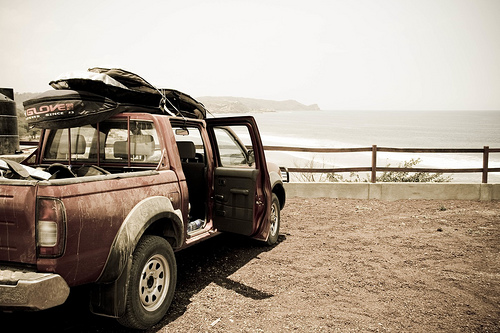

Prompt:


Similar images show

a tent a truck and two men with surfboards are on a rocky beach

an old vintage care is parked with surfboards on top

two people carrying surfboards on a beach where a tent is pitched next to a tree and a truck

a man standing at the trunk of his suv and holding a surfboard.

This image shows 


Generated caption:


a truck parked next to a beach with surfboards


In [7]:
display(image)
print("Prompt:\n\n")
print(tokenizer.decode(decoder_input_ids))

print("\n\nGenerated caption:\n\n")
print(postprocess_preds(tokenizer.decode(pred[0]), tokenizer))